# Figure 2: within-subject encoding

In [2]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import stats
from scipy.stats import pearsonr

from util import subject
from scipy.stats import zscore
from himalaya.scoring import correlation_score

from util import plot
from util.path import Path
from util.stats import ttest_1samp
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
# modelname = "contextual"
# features = ["task", "prod-LLM", "comp-LLM"]

# modelname = "joint_nosplit"
# features = ["task", "spectral", "articulation", "LLM"]

modelname = "joint"
modelname = "joint_syntactic"
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

cache = 'default_task'

encmodel = f"encoding_{cache}"

FG_MASK = get_brainmask()

modelname, encmodel, cache

('joint_syntactic', 'encoding_default_task', 'default_task')

In [5]:
cachedir = f'results/cache/figure2-{encmodel}/{modelname}/{cache}'
resultdir = f'figures/figure2/{encmodel}/{modelname}/{cache}'
!mkdir -p $resultdir
!mkdir -p $cachedir
cachedir

'results/cache/figure2-encoding_default_task/joint_syntactic/default_task'

In [6]:
prod_cmap = 'Blues'
comp_cmap = 'Oranges'

# Load results

In [7]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        for key in ["cv_scores_prod", "cv_scores_comp", "cv_scores"]:
            results[key].append(f[key][...])

100%|██████████| 58/58 [00:02<00:00, 28.07it/s]


In [8]:
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_prod.shape

(58, 5, 5, 81924)

In [9]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_prod.shape

(5, 81924)

In [10]:
all_scores = np.stack(results["cv_scores"])  # sub, run, feature, voxel
avg_scores = np.mean(all_scores, axis=(0, 1))
avg_scores.shape

(5, 81924)

In [11]:
all_scores_lang = all_scores[:, :, -2:].sum(2).mean(1)
avg_scores_lang = all_scores_lang.mean(0)
all_scores_lang.shape, all_scores_lang.min(), all_scores_lang.max()

((58, 81924), -0.10868142, 0.30575335)

## Statistical test

In [12]:
sigmask = ttest_1samp(all_scores_lang, correlations=True, method='bonf', alpha=0.01)#, alternative='greater')
np.save(cachedir + '/sigmask.npy', sigmask)
sigmask.sum()

0

# Plot LLM encoding performance

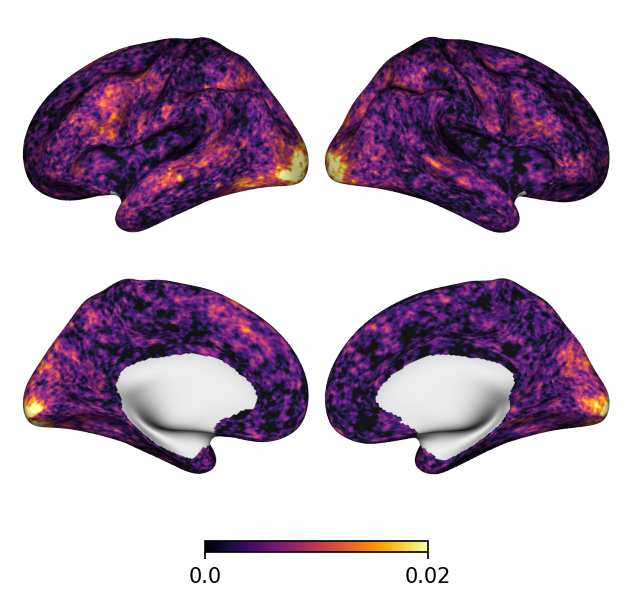

In [16]:
values = avg_scores_lang.copy()

th = ~sigmask
th, vmin = None, 0

# vmin = values[sigmask].min()
# vmax = values[sigmask].max()
# print(vmin, vmax)

fig, ax = plt.subplots()
plot.surface_plot(values, threshold=th, fig=fig, ax=ax, cmap='inferno', vmin=vmin)#, vmax=0.31)
# ax.set_title(cache)
fig.savefig(f'{resultdir}/joint-llm.svg')
fig.show()

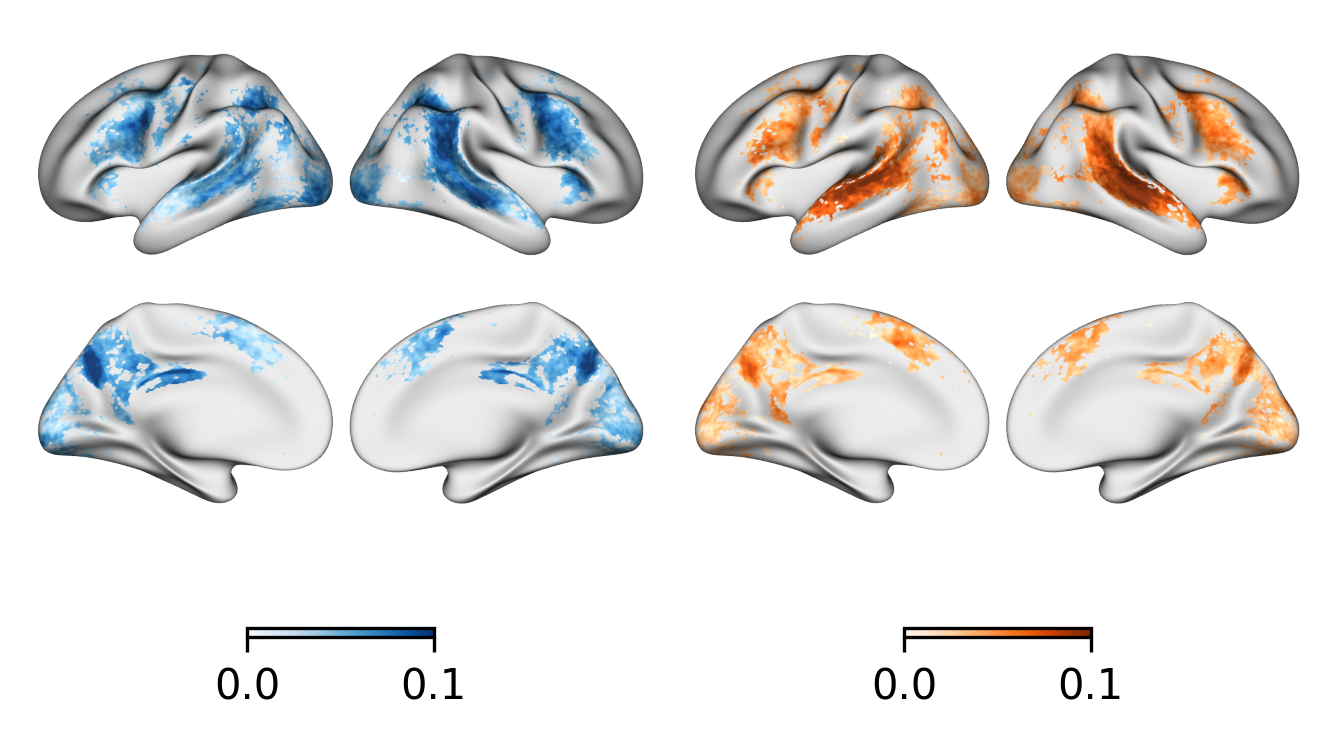

In [23]:
values1 = avg_scores_prod[-2].copy()  # -1 for nosplit
values2 = avg_scores_comp[-1].copy()

th = ~sigmask

vmax = None

fig, axes = plt.subplots(1, 2, figsize=(4.5, 4.5), layout='tight', dpi=300)
plot.surface_plot(values1, threshold=th, fig=fig, ax=axes[0], cmap=prod_cmap, vmin=0, vmax=vmax)
plot.surface_plot(values2, threshold=th, fig=fig, ax=axes[1], cmap=comp_cmap, vmin=0, vmax=vmax)
# fig.suptitle(modelname[6:] + f" ({len(features)} spaces) ({cache})")
fig.show()

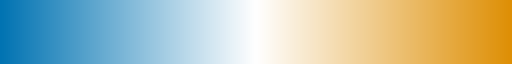

In [24]:
from matplotlib.colors import LinearSegmentedColormap

colors = [BLU, '#ffffff', ORG]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
cmap

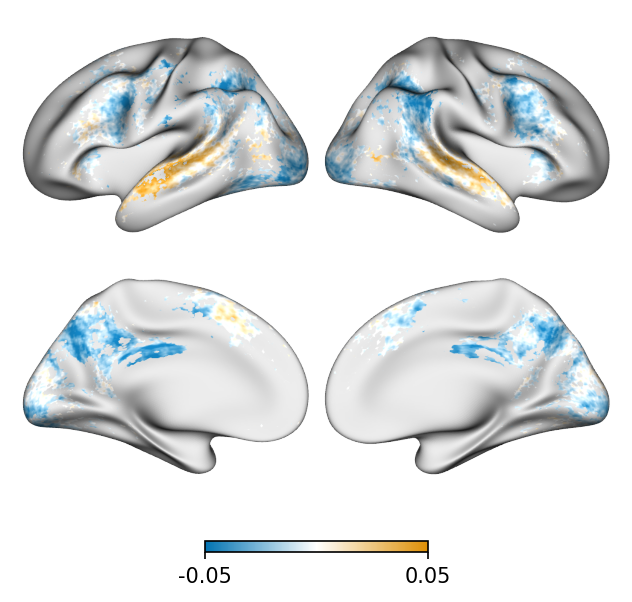

In [25]:
values = values2 - values1

fig, ax = plt.subplots()
plot.surface_plot(values, threshold=th, fig=fig, ax=ax, cmap=cmap)#, vmax=0.05)
fig.savefig(f'{resultdir}/prod-comp-diff.svg')
fig.show()

# scatter prod and comp (skip)

In [21]:
values1 = avg_scores_prod[-2][FG_MASK]
values2 = avg_scores_comp[-1][FG_MASK]
stats.pearsonr(values1, values2), 1/ len(values1)

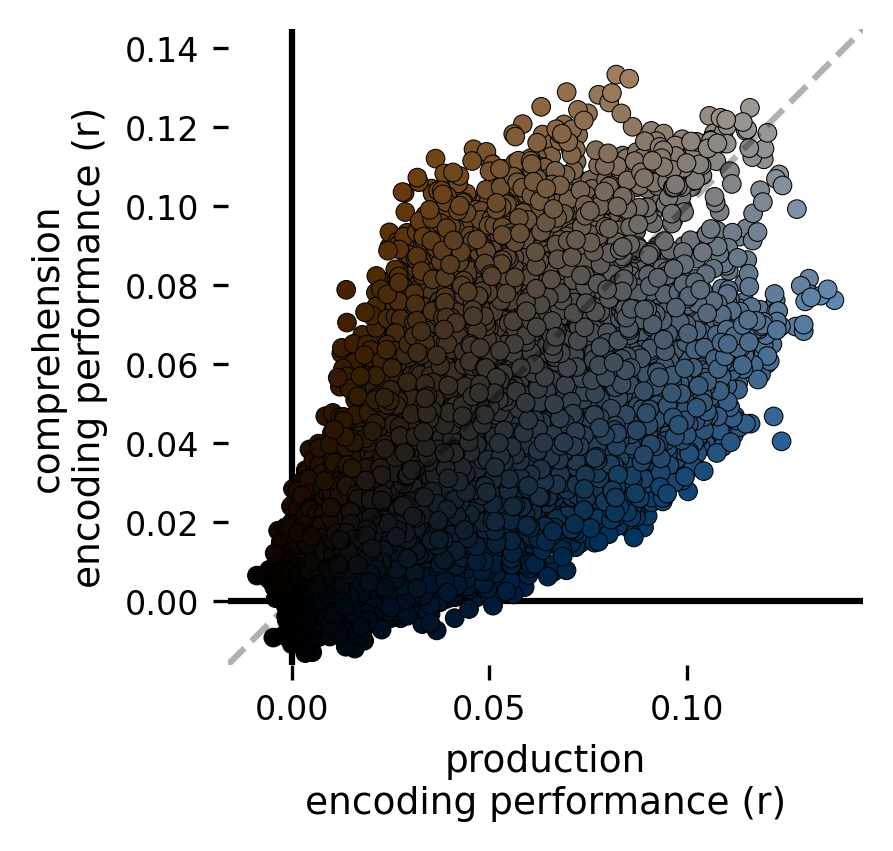

In [115]:
vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=0.2, vmax2=0.2)(
    np.vstack((values1, values2)).T
)
vox_colors = np.stack((vox_colors)).T / 255

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')
# im = ax.hexbin(values1, values2, bins="log", cmap='grey', gridsize=100)
# im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
im = ax.scatter(
    values1, values2, c=vox_colors, s=20,
    edgecolors='black', linewidths=0.25, marker='o')
ax.set_aspect("equal", "box")

# roi_labels = {
#     "aTemp": "RH_Lang_aSTS",
#     "pTemp": "RH_Lang_pSTS",
#     "EAC": "RH_AUD_EAC",
# }
# for label, roi in roi_labels.items():
#     roimask = catlas.roimask([roi])
#     x_roi = np.mean(values1[roimask[fgmask]])
#     y_roi = np.mean(values2[roimask[fgmask]])
#     ax.text(
#         x_roi,
#         y_roi,
#         label,
#         ha="center",
#         va="center",
#         size=8,
#         bbox=dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(0.8, 0.8, 0.8)),
#     )

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)

fig.show()

# encoding performance per feature space

In [19]:
avg_scores.shape, avg_scores_prod.shape, len(features)

((5, 81924), (5, 81924), 5)

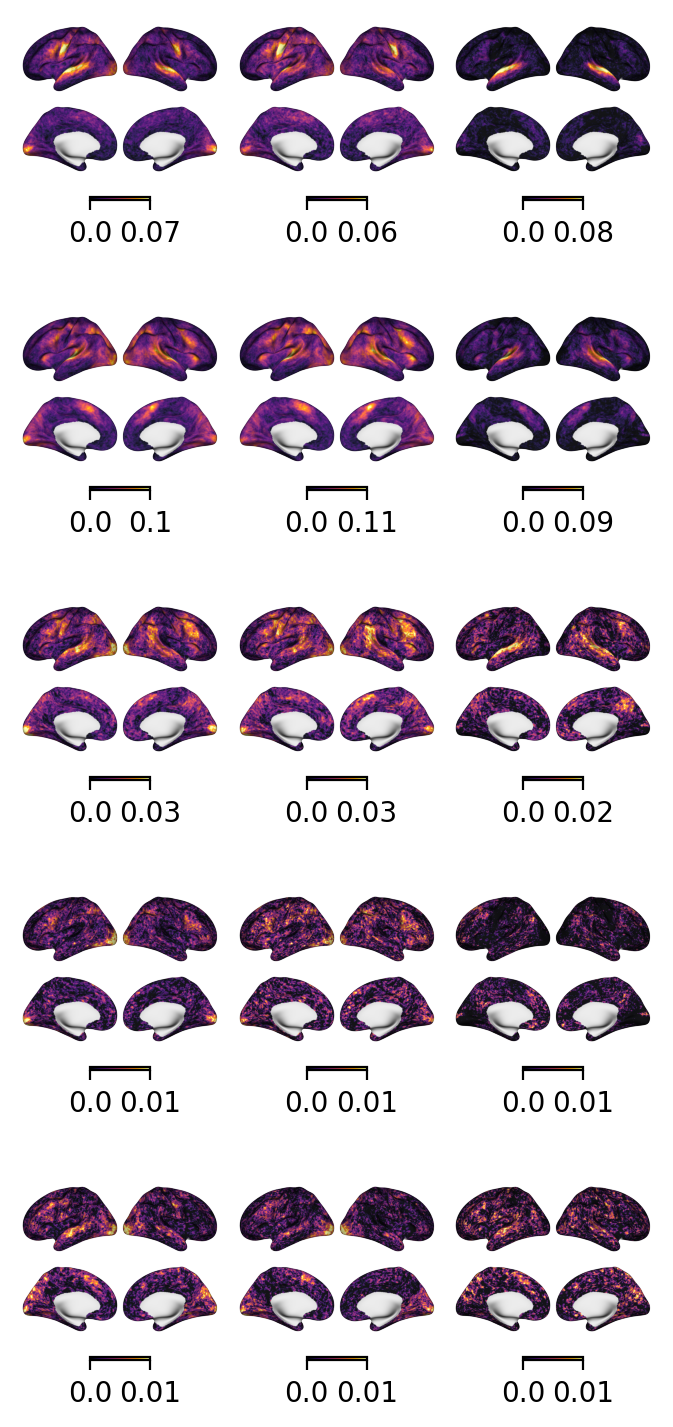

In [20]:
fig, axes = plt.subplots(len(features), 3, figsize=(3.25, 7.25), dpi=200, layout='constrained')
for i, feature in enumerate(features):
    for j, scores in enumerate([avg_scores, avg_scores_prod, avg_scores_comp]):
        ax = axes[i, j]
        plot.surface_plot(scores[i], vmin=0, cmap='inferno', fig=fig, ax=ax)
fig.show()

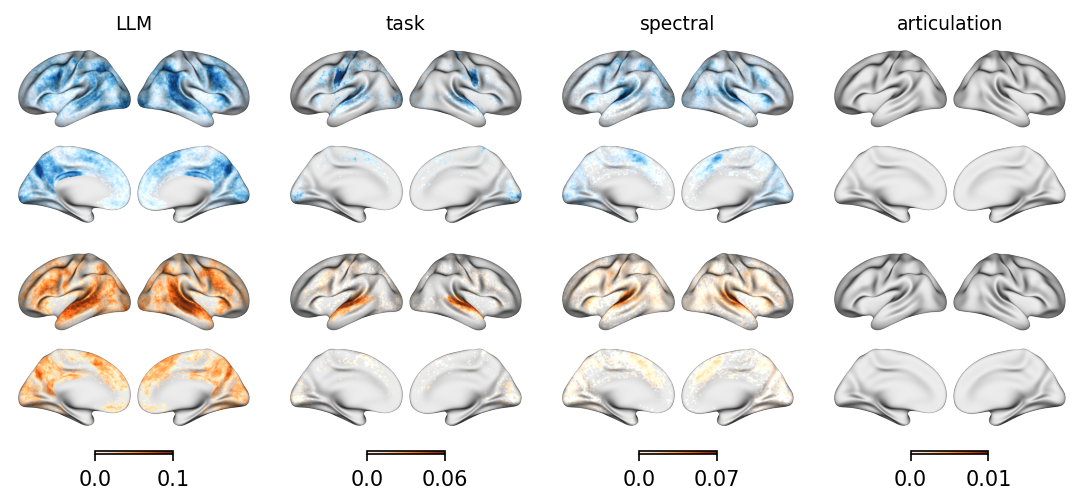

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(7.25, 3.25), layout="constrained")

# joint
# plot.surface_plot(avg_scores_prod.sum(0), fig=fig, ax=axes[0,0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), fig=fig, ax=axes[1,0], vmin=0.0, cmap="hot")

ttest_args = dict(method='fdr_bh', alpha=0.05)
plot_args = dict(vmin=0)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 0, :] + all_scores_comp[:, :, 0, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[0], threshold=brainmask, fig=fig, ax=axes[0, 1], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[0], threshold=brainmask, fig=fig, ax=axes[1, 1], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 1, :] + all_scores_comp[:, :, 1, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[1], threshold=brainmask, fig=fig, ax=axes[0, 2], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[1], threshold=brainmask, fig=fig, ax=axes[1, 2], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 2, :] + all_scores_comp[:, :, 2, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[2], threshold=brainmask, fig=fig, ax=axes[0, 3], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[2], threshold=brainmask, fig=fig, ax=axes[1, 3], cmap=comp_cmap, cbar=True, **plot_args)

# brainmask  = ~ ttest_sig(np.mean(all_scores_prod[:, :, 3, :] + all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 3, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[3], threshold=brainmask, fig=fig, ax=axes[0, 0], cmap=prod_cmap, cbar=False, **plot_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_comp[4], threshold=brainmask, fig=fig, ax=axes[1, 0], cmap=comp_cmap, cbar=True, **plot_args)

axes[0, 0].set_title("LLM")
axes[0, 1].set_title("task")
axes[0, 2].set_title("spectral")
axes[0, 3].set_title("articulation")

axes[0, 0].set_ylabel('production')
axes[1, 0].set_ylabel('comprehension')

fig.show()

# weight similarity

In [7]:
# sim between prod and comp
weight_sim_within = []

respath = Path(
    root='results/' + encmodel + '_n2',
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prod = f["cv_weights_prod"][...].mean(0)
        weights_comp = f["cv_weights_comp"][...].mean(0)

    raw_corrs = correlation_score(weights_prod, weights_comp)
    weight_sim_within.append(raw_corrs)

weight_sim_within = np.stack(weight_sim_within)
weight_sim_within.shape

100%|██████████| 58/58 [06:05<00:00,  6.30s/it]


(58, 81924)

In [17]:
th = ~sigmask

values = weight_sim_within.mean(0)

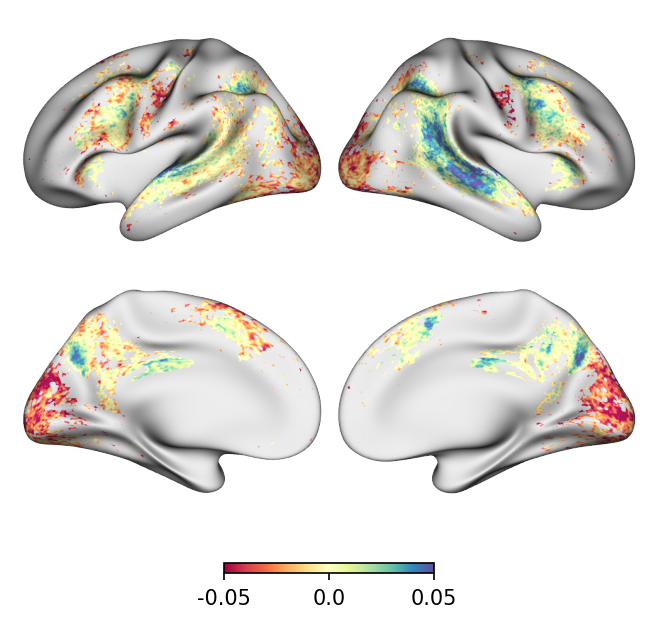

In [28]:
fig = plot.surface_plot(values, threshold=th, cmap="Spectral", vmax=.05)
fig.savefig(f'{resultdir}/within-weight-sim.svg')

In [76]:
values1 = avg_scores_prod[-2][FG_MASK]
values2 = avg_scores_comp[-1][FG_MASK]
stats.pearsonr(values1, values2), 1/ len(values1)

(PearsonRResult(statistic=0.6361995871090597, pvalue=0.0),
 1.3342762218634503e-05)

In [ ]:
vox_colors = weight_sim_within.mean(0)[FG_MASK]
order = vox_colors.argsort()

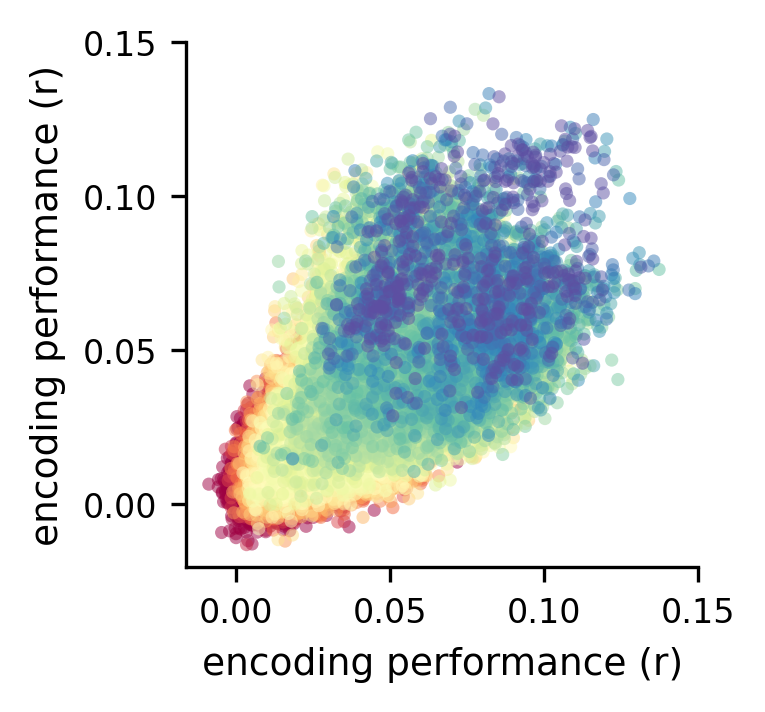

In [75]:
fig, ax = plt.subplots(figsize=(2.2, 2.75), dpi=300)

im = ax.scatter(
    values1[order], values2[order], c=vox_colors[order],
    s=10, alpha=0.5,
    cmap='Spectral', vmin=-0.05, vmax=0.05,
    edgecolors='none', marker='o')
ax.set_aspect("equal", "box")

ticks = np.arange(0, .15 + .01, .05)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlabel("encoding performance (r)")
ax.set_ylabel("encoding performance (r)")

fig.savefig(f'{resultdir}/scatter-prod-comp.png', dpi=300, bbox_inches='tight')
fig.show()

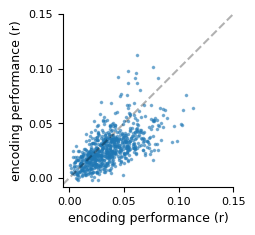

In [68]:
fig, ax = plt.subplots(figsize=(2.2, 2.75), dpi=100)

ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')

im = ax.scatter(values1[::100], values2[::100], s=10, alpha=0.5, marker='.')
ax.set_aspect("equal", "box")

ticks = np.arange(0, .15 + .01, .05)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlabel("encoding performance (r)")
ax.set_ylabel("encoding performance (r)")

fig.savefig(f'{resultdir}/scatter-prod-comp.svg')
fig.show()

# Joint ROI-level

In [26]:
catlas = Atlas.load("custom_glasser_group")

In [27]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
scoresC = catlas.vox_to_parc(avg_scores_comp)
scoresP.shape

(5, 22)

In [28]:
df = pd.DataFrame(index=catlas.labels)
df["task"] = scoresP[0] + scoresC[0]
df["spectral"] = scoresP[1] + scoresC[1]
df["articulation"] = scoresP[2] + scoresC[2]
df["prod-LLM"] = scoresP[3]
df["comp-LLM"] = scoresC[4]
df.head()

task  spectral  articulation  prod-LLM  comp-LLM
LH_EAC   0.045342  0.111386      0.004990  0.031570  0.041899
LH_pSTG  0.027567  0.039921      0.008498  0.053969  0.055429
LH_aSTG  0.047500  0.040521      0.007481  0.045008  0.069568
LH_IFG   0.016633  0.019002      0.005017  0.046262  0.041063
LH_FOP   0.015474  0.032937      0.005611  0.038126  0.028421

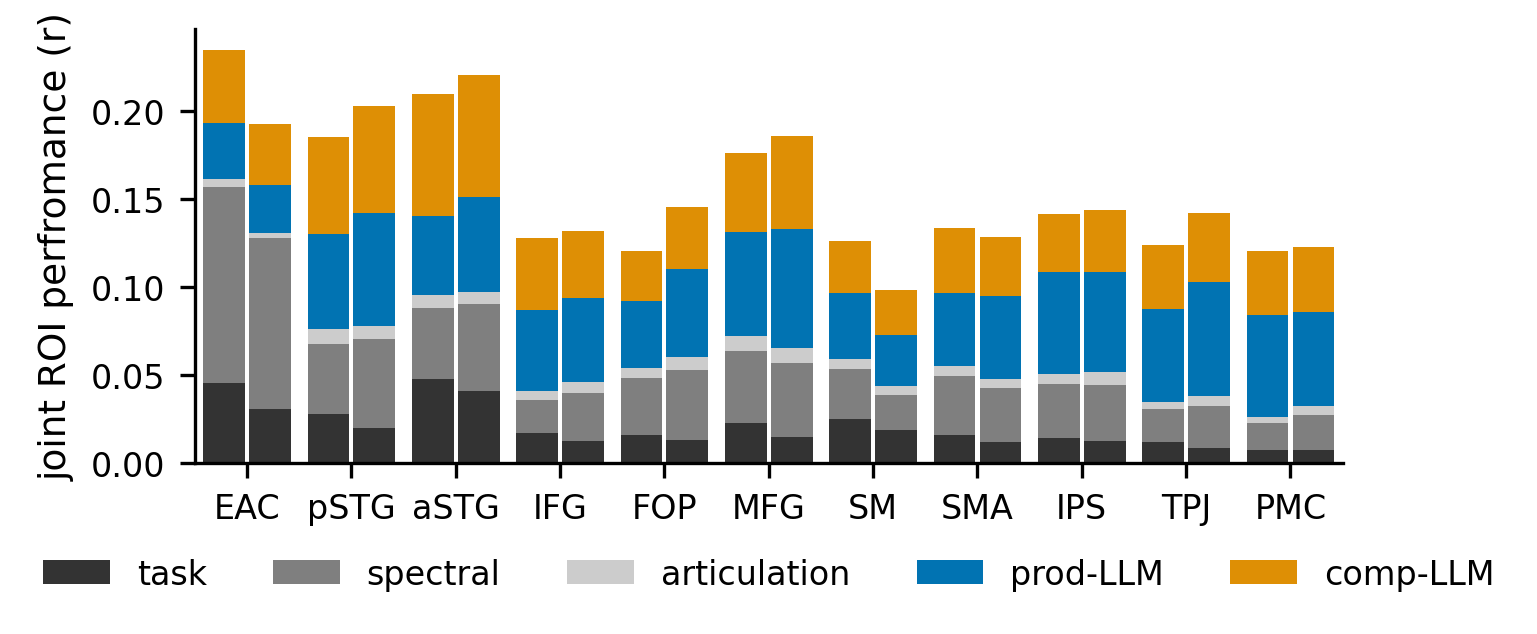

In [36]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

subdf1 = df.iloc[:len(df)//2]
subdf = df.iloc[len(df)//2:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]

xaxis = np.arange(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf1[feature]
    p = ax.bar(xaxis - .02, values, -width, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xaxis + .02, values, width, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)

ax.set_ylabel('joint ROI perfromance (r)')
# ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
sns.despine(fig)

fig.savefig(f"{resultdir}/barplot-joint.svg")
fig.show()

## plot brains

In [32]:
from surfplot import Plot

In [ ]:
for i, label in enumerate(catlas.labels[:len(catlas)//2], 1):
    roimask = catlas.roimask([i]).astype(int)

    view = 'lateral'
    if 'SMA' in label or 'PMC' in label:
        view = 'medial'

    p = Plot("mats/suma-fsaverage6/lh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer(roimask[:roimask.size//2], cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.savefig(f"{resultdir}/roi-{label}_map.svg")
    fig.show()

# correlate model predictions with FD

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results_prod = []
results_comp = []

for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        preds = f['cv_preds'][...]
        prodmask = f['cv_prodmask'][...]
        scores_prod = f['cv_scores_prod'][...]
        fwd = subject.get_confounds(sub).reshape(5, 240)

    for i in range(5):
        fd_prod_r = correlation_score(fwd[i, prodmask[i]][:, None], preds[i, -2, prodmask[i]])
        fd_comp_r = correlation_score(fwd[i, ~prodmask[i]][:, None], preds[i, -1, ~prodmask[i]])

        results_prod.append(fd_prod_r)
        results_comp.append(fd_comp_r)

In [168]:
values1 = np.stack(results_prod).mean(0)
values2 = np.stack(results_comp).mean(0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(4.5, 4.5), layout='tight', dpi=300)
plot.surface_plot(values1, fig=fig, ax=axes[0], title='prod')
plot.surface_plot(values2, fig=fig, ax=axes[1], title='comp')
fig.show()

# multiple ways to compute encoding performance

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

subA = 105
respath.update(sub=f"{subA:03d}")
print(respath.fpath)
with h5py.File(respath, "r") as f:
    preds = f['cv_preds'][...]
    prodmask = f['cv_prodmask'][...]
    scores = f['cv_scores'][...]
    scores_comp = f['cv_scores_comp'][...]
    scores_prod = f['cv_scores_prod'][...]
    fwd = subject.get_confounds(sub).reshape(5, 240)

fwd = subject.get_confounds(sub)
dataA = subject.get_bold(subA, cache=cache)
prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)

dataA.shape, preds.shape, prod_boxcar.shape,  prodmask.shape, scores_prod.shape, fwd.shape

In [ ]:
# find a good voxel
vox = scores_prod[0, -2].argmax(-1)
vox = scores[0, -2:].sum(0).argmax()
vox = scores[0, 0].argmax()
print(vox)

print(scores[0, :, vox].round(3))
print(scores_prod[0, :,  vox].round(3))
print(scores_comp[0, :,  vox].round(3))

In [ ]:
print(scores[0, :, vox].sum().round(3))
print(pearsonr(preds[0, :, :, vox].sum(0), dataA[:240, vox]).statistic.round(3))

In [80]:
from himalaya.scoring import correlation_score_split

In [ ]:
print(correlation_score_split(dataA[:240, vox:vox+1], preds[0, :, :, vox:vox+1]).ravel().round(3))
print(correlation_score(dataA[:240, vox:vox+1], preds[0, :, :, vox:vox+1]).ravel().round(3))

In [ ]:
print(np.array([pearsonr(preds[0, i, :, vox], dataA[:240, vox]).statistic for i in range(5)]).round(3))

In [ ]:
y = dataA[:120, vox]
yhat_p = preds[0, -2, :120, vox]
yhat_c = preds[0, -1, :120, vox]
yhat_t = preds[0, 0, :120, vox]
pmask = prodmask[0, :120]
y.shape, yhat_c.shape, pmask.shape

In [ ]:
print('prod', pearsonr(y, yhat_p))
print('comp', pearsonr(y, yhat_c))
print('both', pearsonr(y, yhat_p + yhat_c))
print('masked:')
print('prod', pearsonr(y[pmask], yhat_p[pmask]))
print('comp', pearsonr(y[~pmask], yhat_c[~pmask]))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# ax.plot(y, c='k', alpha=0.2)
# ax.plot(pmask * 3, c='k')
# ax.plot(zscore(yhat_p), color=BLU)
ax.plot(yhat_t, color=BLU)

# ax.set_ylim(-3, 3)
plt.show()

In [ ]:
yhat_c

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y, c='k', alpha=0.2)
ax.plot(~pmask * 3, c='k')
ax.plot(zscore(yhat_c), color=ORG)

ax.set_ylim(-3, 3)
plt.show()

# compare with head motion

In [ ]:
stat = np.mean

prod_fds = []
comp_fds = []
prod_scs = []
comp_scs = []

for subA in tqdm(SUBS_STRANGERS):
    fd = subject.get_confounds(subA, confounds=['framewise_displacement'])
    fd = fd.reshape(5, 240)

    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_mask = f["cv_prodmask"][...]
        prod_scores = f["cv_scores_prod"][:, -2]
        comp_scores = f["cv_scores_comp"][:, -1]
    
    for i in range(5):
        prod_fd = fd[i, prod_mask[i]]
        comp_fd = fd[i, ~prod_mask[i]]
        prod_sc = prod_scores[i]
        comp_sc = comp_scores[i]

        prod_fds.append(stat(prod_fd, axis=-1))
        comp_fds.append(stat(comp_fd, axis=-1))
        prod_scs.append(stat(prod_sc, axis=-1))
        comp_scs.append(stat(comp_sc, axis=-1))


In [ ]:
r_prod = stats.pearsonr(prod_fds, prod_scs)
r_comp = stats.pearsonr(comp_fds, comp_scs)
print(r_prod)
print(r_comp)

In [ ]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=200)

ax.scatter(prod_fds, prod_scs, alpha=0.7, c=BLU, s=20, label=f'prod (r={r_prod.statistic:.3f}, p={r_prod.pvalue:.3f})', edgecolors='black', linewidths=0.25)
ax.scatter(comp_fds, comp_scs, alpha=0.7, c=ORG, s=20, label=f'comp (r={r_comp.statistic:.3f}, p={r_comp.pvalue:.3f})', edgecolors='black', linewidths=0.25)
ax.set_xlabel('framewise displacement per run (mm)')
ax.set_ylabel('average encoding performance (r)')
ax.legend(loc="upper left", bbox_to_anchor=(0.58, 1))
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=200)
ax.hist(prod_fds, bins=25, alpha=0.7, color=BLU, label='production')
ax.hist(comp_fds, bins=25, alpha=0.7, color=ORG, label='comprehension')
ax.legend()
ax.set_xlabel('framewise displacement')
fig.show()

# verify regressors

In [162]:
# import sys
# from importlib import reload
# reload(sys.modules["encoding"])

from encoding import build_regressors, SPACES

In [ ]:
subA

In [ ]:
X, features = build_regressors(subA, modelname='model-gpt2-2b_layer-24', spaces=SPACES['joint'])
X.shape, features

In [ ]:
X, features = build_regressors(subA, modelname='model-gpt2-2b_layer-24', spaces=SPACES['joint'])
X.shape, features

In [ ]:
x_trial = X[:120]
x_trial.shape

In [ ]:
x_feature = x_trial[:, features['task']]
n_vars = x_feature.shape[1]

fig, axes = plt.subplots(n_vars, 1, sharex=True)

for i, ax in enumerate(axes):
    ax.plot(x_feature[:, i])

fig.show()

In [ ]:
x_feature = x_trial[:, features['spectral']]
n_vars = x_feature.shape[1]

plt.matshow(x_feature.T, cmap='coolwarm', vmin=-.9, vmax=.9)
plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['articulation']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['prod_semantic']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature[:40], cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['comp_semantic']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature[:40], cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()

x_feature.shape